# Origen de los eventos simulados puros

Como vimos en el notebook anterior, el RF que clasifica eventos entre MC y Reales diferenciaba muy bien una gran cantidad de sucesos que eran simulados de los que no lo eran y solo confundía una parte de ellos. Para empezar, representaremos los dos espectros y ver cómo son y para seguir analizaremos en profundidad por qué los diferencia tan bien.

Una posibilidad es que los MC realmente se simulan con una energía que sigue la recta E^(-2.0) cuando realmente el espectro de energías de rayos cósmicos es E^(-2.7). Esto se hace debido a que escogiendo -2.7 en vez de -2.0 no habría sucesos simulados de energías muy altas cuando realmente sí se obtienen.

Más adelante analizaremos los diferentes parámetros de Hillas de cada uno de ellos para ver si encontramos alguna relación entre ellos.

## 1. Espectro de simulados y reales

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader, read_table
import scipy

# RandomForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Distribución del clasificador
import scipy.stats as stats

/tmp/ipykernel_18871/1269661234.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Espectro con corte de intensidad 

In [4]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

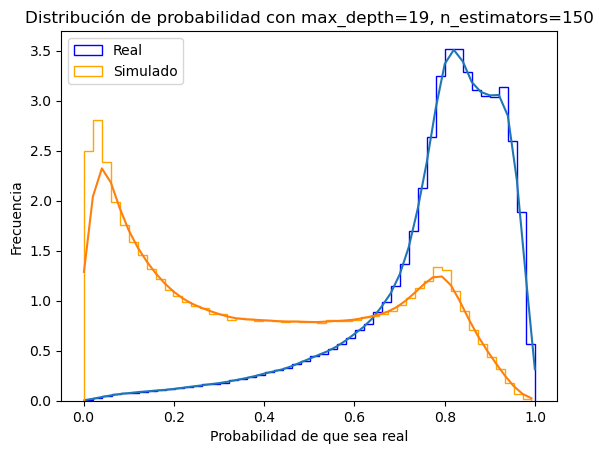

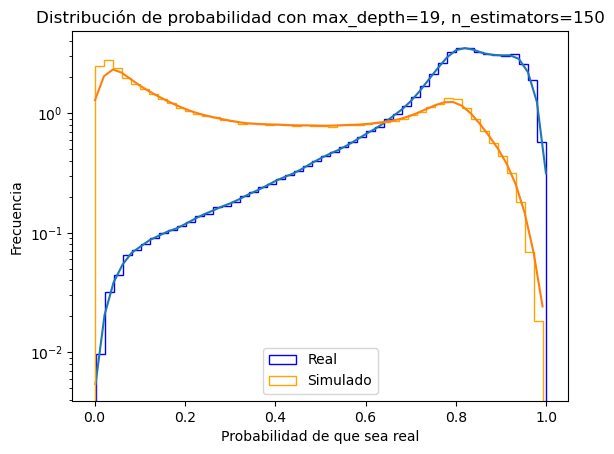

In [6]:
y_pred = (rfrs.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

In [7]:
# Vamos a guardar los resultados antes de nada

np.savetxt("X_test_intcut", X_test)
np.savetxt("X_train_intcut", X_train)
np.savetxt("y_test_intcut", y_test)
np.savetxt("y_train_intcut", y_train)
np.savetxt("y_pred_intcut", y_pred)

#### Espectro sin corte de intensidad

In [8]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs2 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs2.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

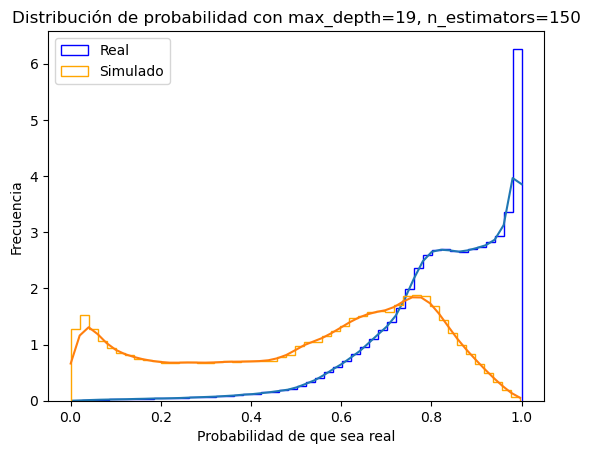

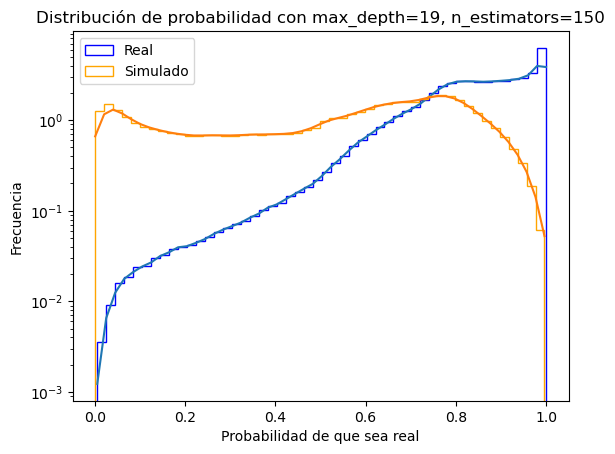

In [10]:
y_pred = (rfrs2.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

In [11]:
# Vamos a guardar los resultados antes de nada

np.savetxt("X_test_total", X_test)
np.savetxt("X_train_total", X_train)
np.savetxt("y_test_total", y_test)
np.savetxt("y_train_total", y_train)
np.savetxt("y_pred_total", y_pred)

Vamos a intentar sacar de cada distribución las pobalciones de simulados más simulados, simulados más reales y reales más reales para estudiar sus parámetros de Hillas para ver valores tienen para que el RF los pueda diferenciar tan bien.

In [2]:
# Cargamos los datos generados anteriormente para no tener que volver a entrenar el RandomForest:
X_test_total = np.loadtxt("X_test_total")
X_train_total = np.loadtxt("X_train_total")
y_test_total = np.loadtxt("y_test_total")
y_train_total = np.loadtxt("y_train_total")
y_pred_total = np.loadtxt("y_pred_total")

X_test_intcut = np.loadtxt("X_test_intcut")
X_train_intcut = np.loadtxt("X_train_intcut")
y_test_intcut = np.loadtxt("y_test_intcut")
y_train_intcut = np.loadtxt("y_train_intcut")
y_pred_intcut = np.loadtxt("y_pred_intcut")

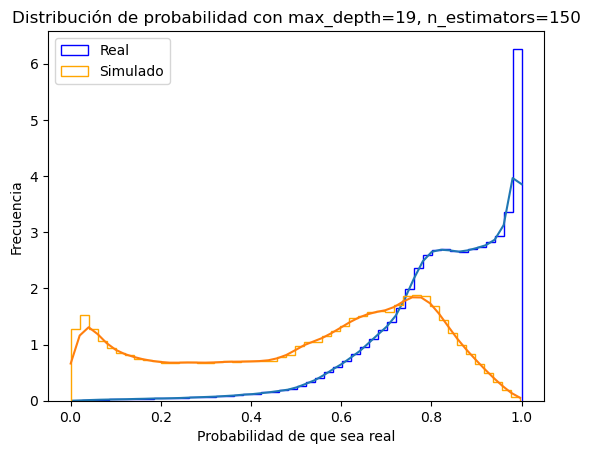

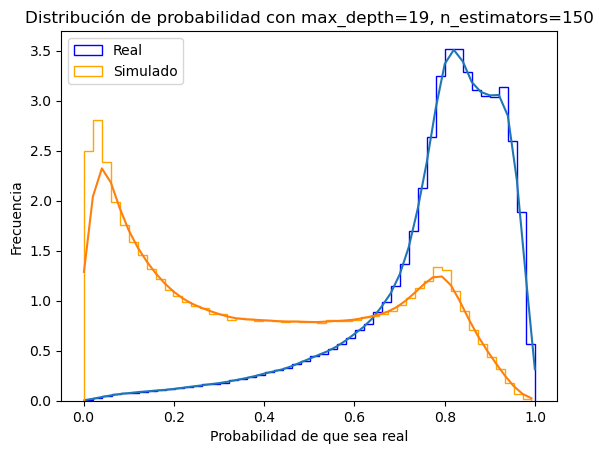

In [3]:
# Los representamos para ver que la distribución es la misma
proba = y_pred_total[:,0]                                                                        # Probabilidad de que el suceso sea un gamma
label = y_test_total                                                                             # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

proba = y_pred_intcut[:,0]                                                                       # Probabilidad de que el suceso sea un gamma
label = y_test_intcut                                                                            # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

## 2. Estudio de los parámetros de Hillas

Vamos a estudiar los parámetros de los sucesos simulados más simulados, los simulados más reales y los reales más reales para ver si encontramos alguna relación entre ellos y así determinar por qué el RF los clasifica así.

### 2.1 Parámetros en función de gammaness

In [4]:
# Preparamos la representación
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]), len(bins))
    plt.hist(x, bins=logbins, alpha = 0.7)

#### Intensidad

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


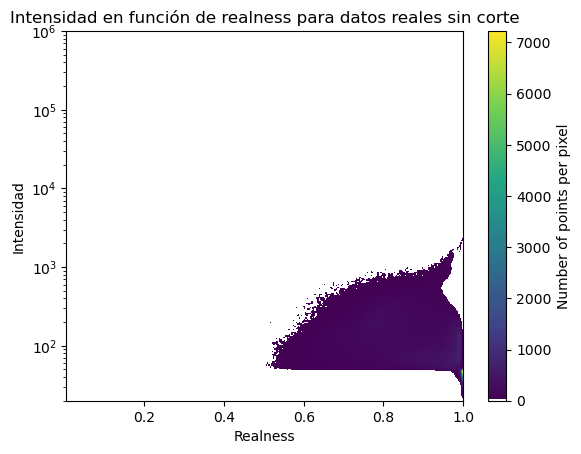

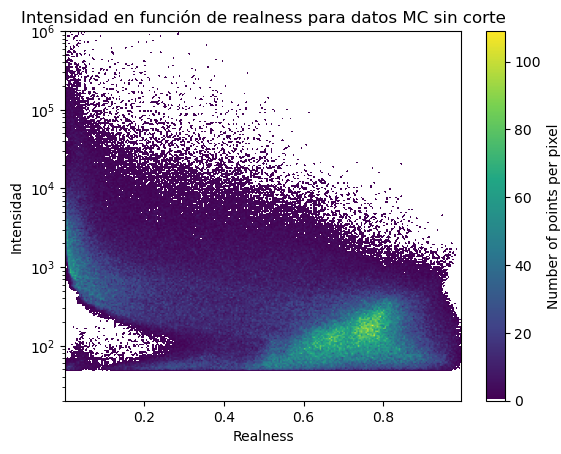

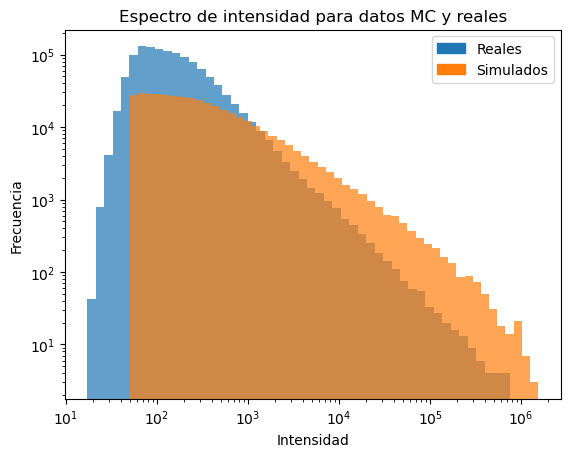

In [5]:
x_int = y_pred_total[:,0]
y_int = X_test_total[:,0]
label = y_test_total

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Intensidad')
plt.yscale('log')
plt.title('Intensidad en función de realness para datos reales sin corte')
plt.ylim(20, 1000000)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Intensidad')
plt.yscale('log')
plt.title('Intensidad en función de realness para datos MC sin corte')
plt.ylim(20, 1000000)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plot_loghist(y_label_0, 50)
plot_loghist(y_label_1, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Intensidad')
plt.title('Espectro de intensidad para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

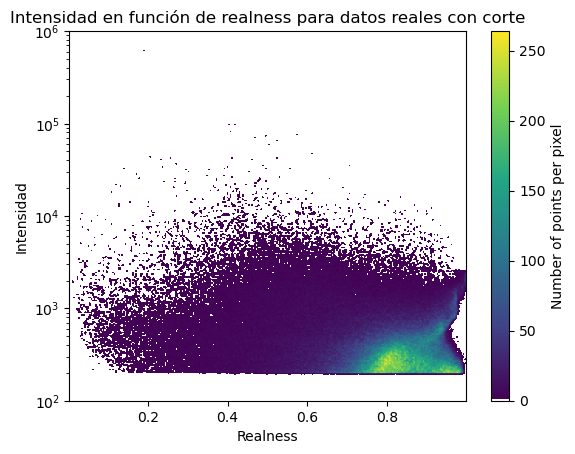

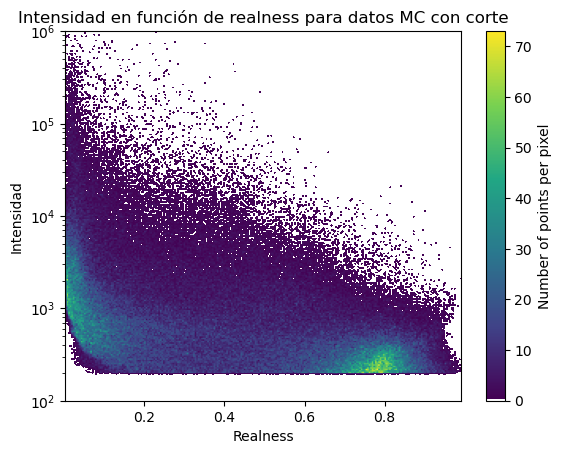

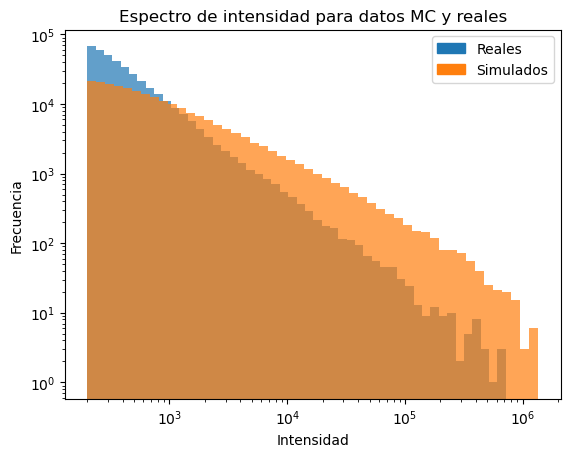

In [6]:
x_int = y_pred_intcut[:,0]
y_int = X_test_intcut[:,0]
label = y_test_intcut

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Intensidad')
plt.yscale('log')
plt.title('Intensidad en función de realness para datos reales con corte')
plt.ylim(100, 1000000)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Intensidad')
plt.yscale('log')
plt.title('Intensidad en función de realness para datos MC con corte')
plt.ylim(100, 1000000)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plot_loghist(y_label_0, 50)
plot_loghist(y_label_1, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Intensidad')
plt.title('Espectro de intensidad para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

#### Skewness

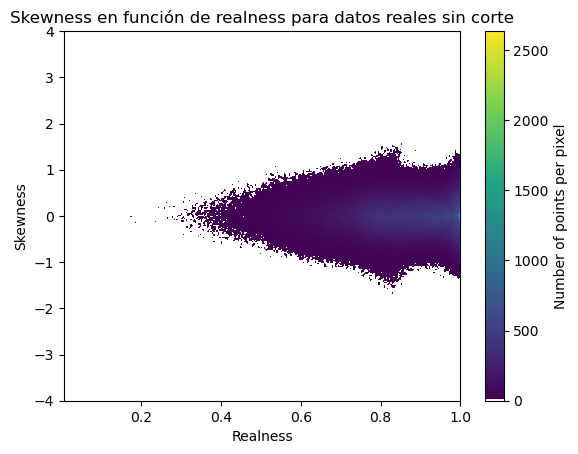

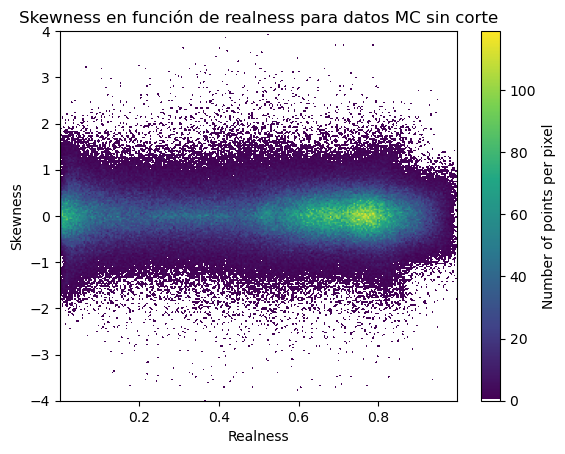

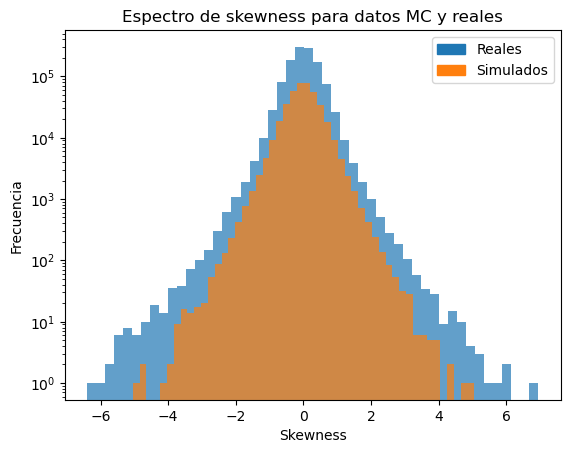

In [7]:
x_int = y_pred_total[:,0]
y_int = X_test_total[:,1]
label = y_test_total

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Skewness')
plt.title('Skewness en función de realness para datos reales sin corte')
plt.ylim(-4, 4)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Skewness')
plt.title('Skewness en función de realness para datos MC sin corte')
plt.ylim(-4, 4)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plt.hist(y_label_0, 50, alpha = 0.7)
plt.hist(y_label_1, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Skewness')
plt.title('Espectro de skewness para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

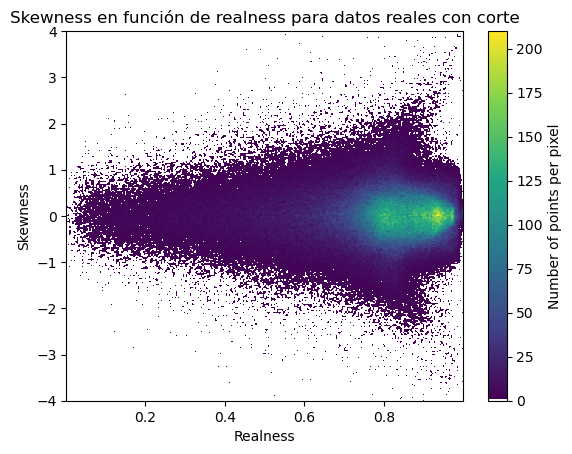

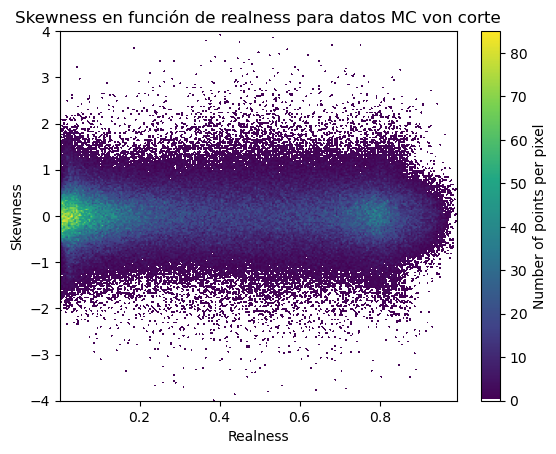

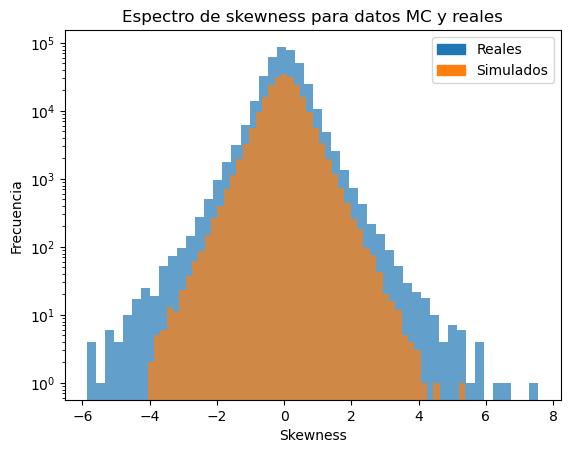

In [8]:
x_int = y_pred_intcut[:,0]
y_int = X_test_intcut[:,1]
label = y_test_intcut

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Skewness')
plt.title('Skewness en función de realness para datos reales con corte')
plt.ylim(-4, 4)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Skewness')
plt.title('Skewness en función de realness para datos MC von corte')
plt.ylim(-4, 4)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plt.hist(y_label_0, 50, alpha = 0.7)
plt.hist(y_label_1, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Skewness')
plt.title('Espectro de skewness para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

#### Kurtosis

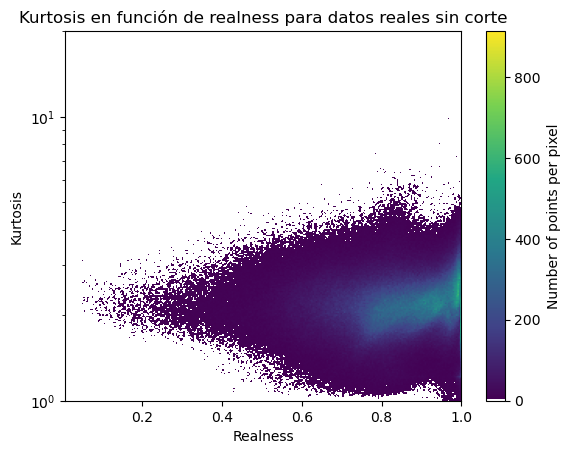

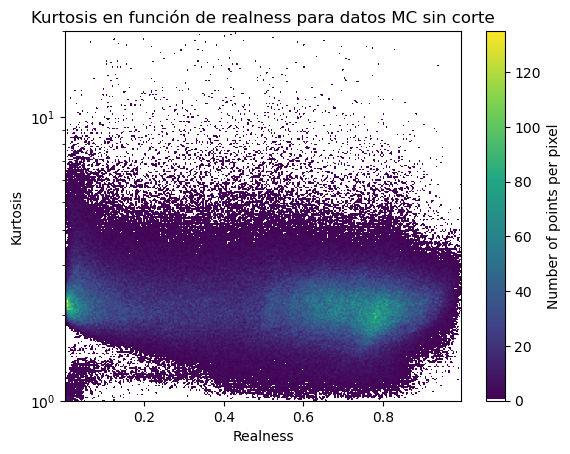

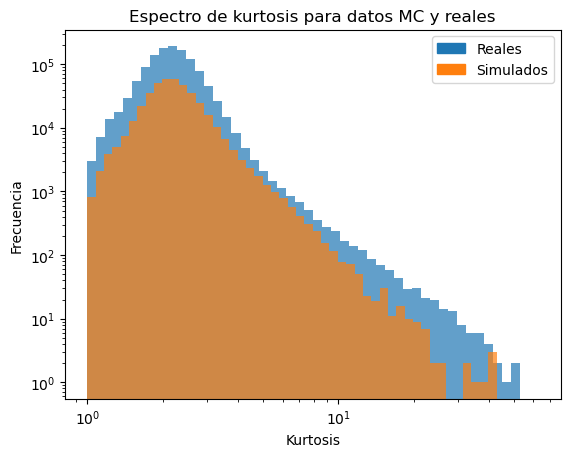

In [9]:
x_int = y_pred_total[:,0]
y_int = X_test_total[:,2]
label = y_test_total

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Kurtosis')
plt.yscale('log')
plt.title('Kurtosis en función de realness para datos reales sin corte')
plt.ylim(1, 20)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Kurtosis')
plt.yscale('log')
plt.title('Kurtosis en función de realness para datos MC sin corte')
plt.ylim(1, 20)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plot_loghist(y_label_0, 50)
plot_loghist(y_label_1, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Kurtosis')
plt.title('Espectro de kurtosis para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

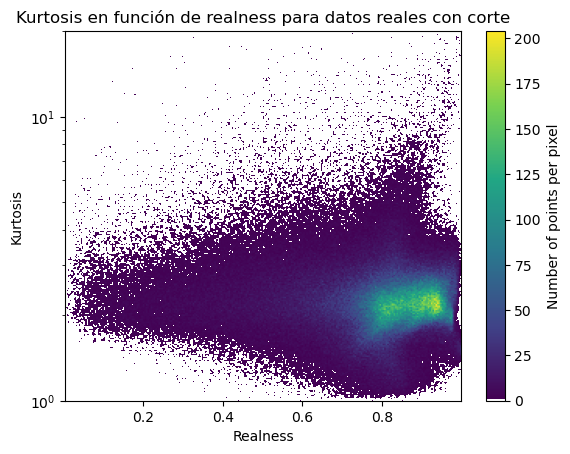

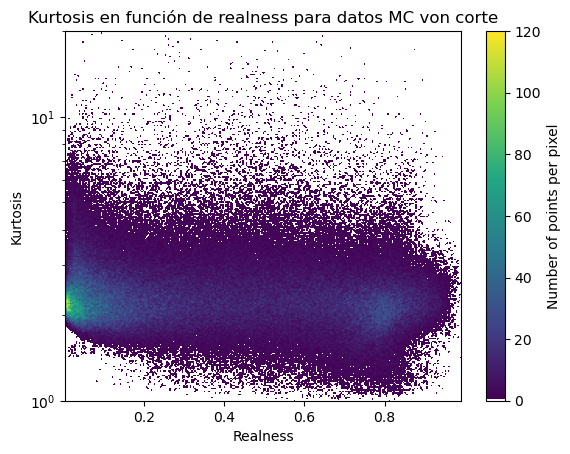

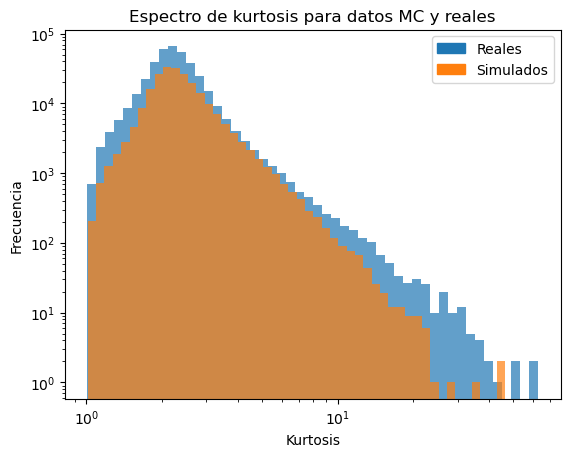

In [10]:
x_int = y_pred_intcut[:,0]
y_int = X_test_intcut[:,2]
label = y_test_intcut

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Kurtosis')
plt.yscale('log')
plt.title('Kurtosis en función de realness para datos reales con corte')
plt.ylim(1, 20)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Kurtosis')
plt.yscale('log')
plt.title('Kurtosis en función de realness para datos MC von corte')
plt.ylim(1, 20)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plot_loghist(y_label_0, 50)
plot_loghist(y_label_1, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Kurtosis')
plt.title('Espectro de kurtosis para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

#### Length

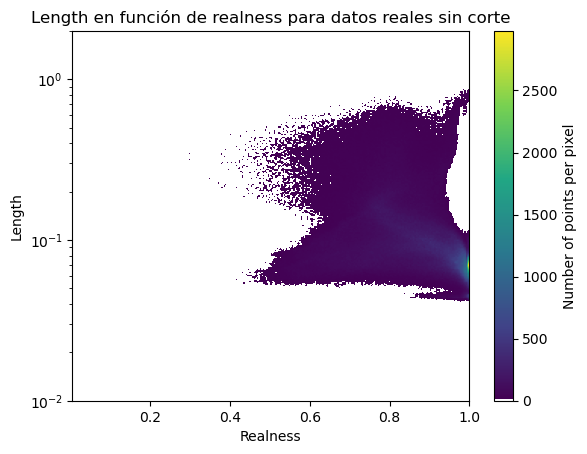

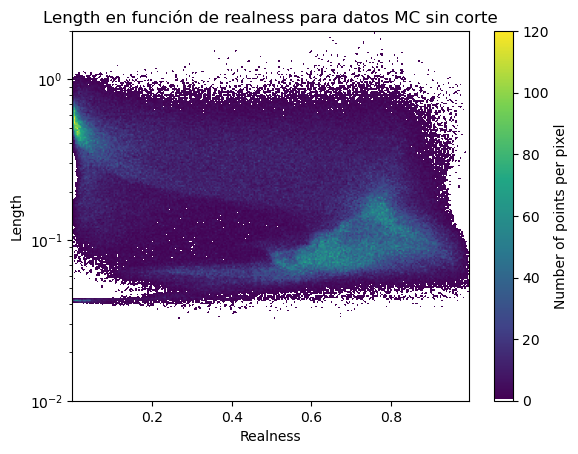

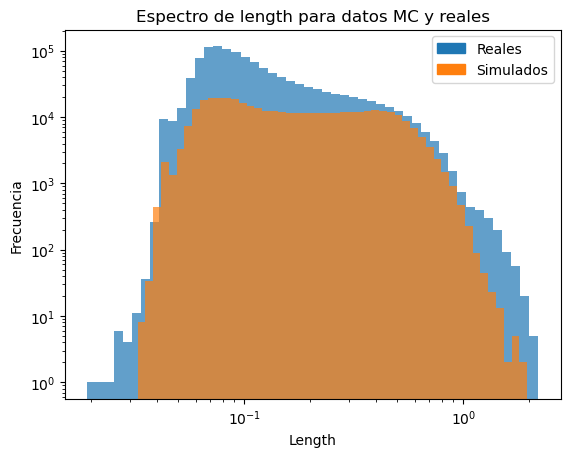

In [11]:
x_int = y_pred_total[:,0]
y_int = X_test_total[:,3]
label = y_test_total

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Length')
plt.yscale('log')
plt.title('Length en función de realness para datos reales sin corte')
plt.ylim(0.01, 2)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Length')
plt.yscale('log')
plt.title('Length en función de realness para datos MC sin corte')
plt.ylim(0.01, 2)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plot_loghist(y_label_0, 50)
plot_loghist(y_label_1, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Length')
plt.title('Espectro de length para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

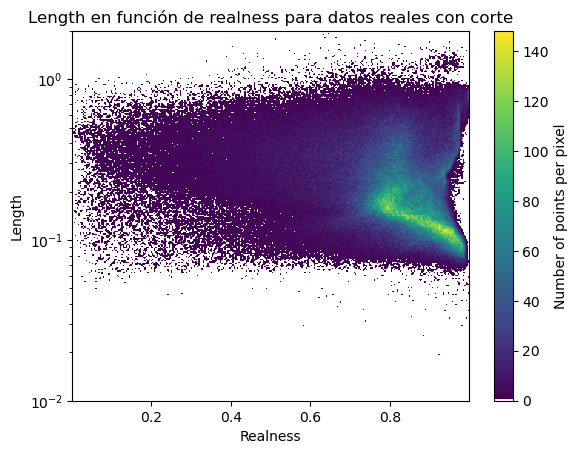

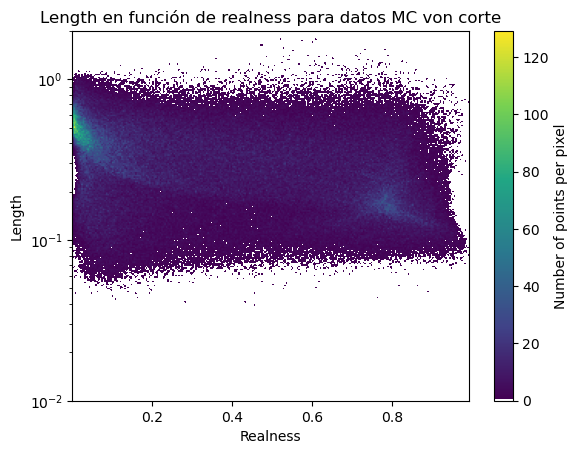

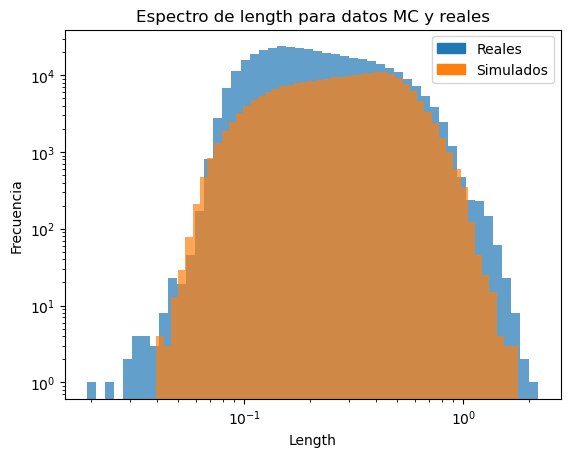

In [12]:
x_int = y_pred_intcut[:,0]
y_int = X_test_intcut[:,3]
label = y_test_intcut

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Length')
plt.yscale('log')
plt.title('Length en función de realness para datos reales con corte')
plt.ylim(0.01, 2)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Length')
plt.yscale('log')
plt.title('Length en función de realness para datos MC von corte')
plt.ylim(0.01, 2)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plot_loghist(y_label_0, 50)
plot_loghist(y_label_1, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Length')
plt.title('Espectro de length para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

#### Width

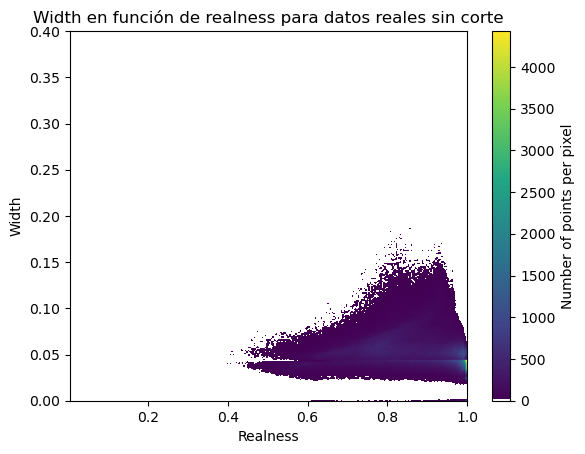

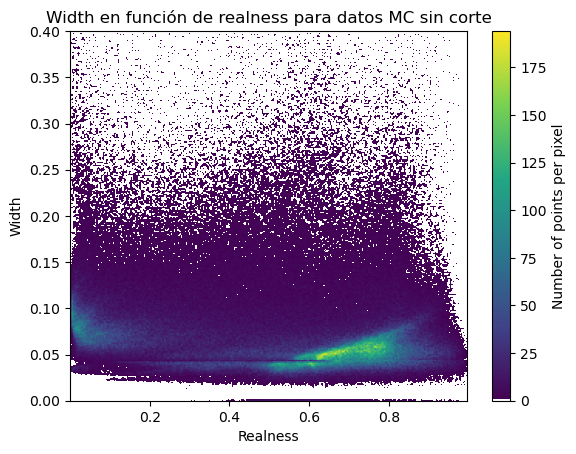

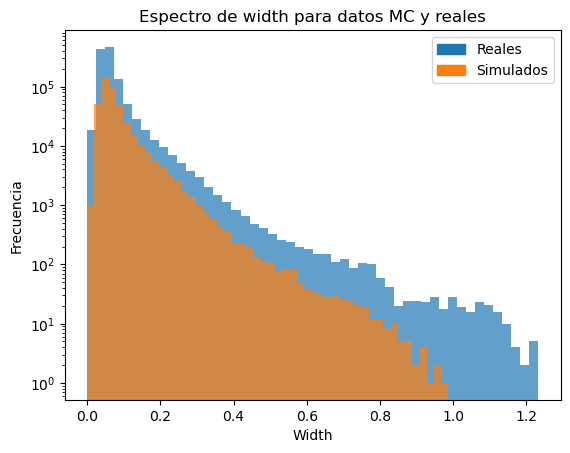

In [14]:
x_int = y_pred_total[:,0]
y_int = X_test_total[:,4]
label = y_test_total

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Width')
plt.title('Width en función de realness para datos reales sin corte')
plt.ylim(0, 0.4)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Width')
plt.title('Width en función de realness para datos MC sin corte')
plt.ylim(0, 0.4)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plt.hist(y_label_0, 50, alpha = 0.7)
plt.hist(y_label_1, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Width')
plt.title('Espectro de width para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

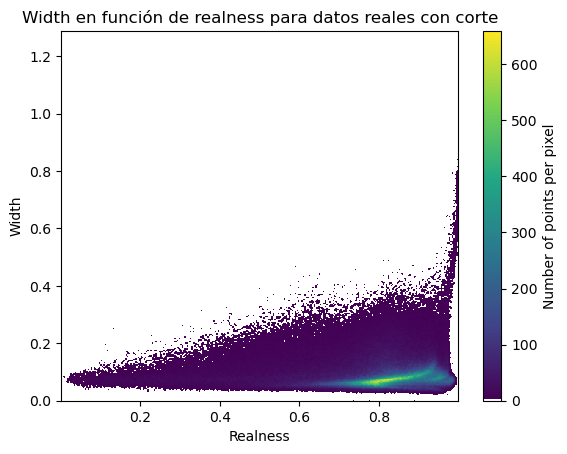

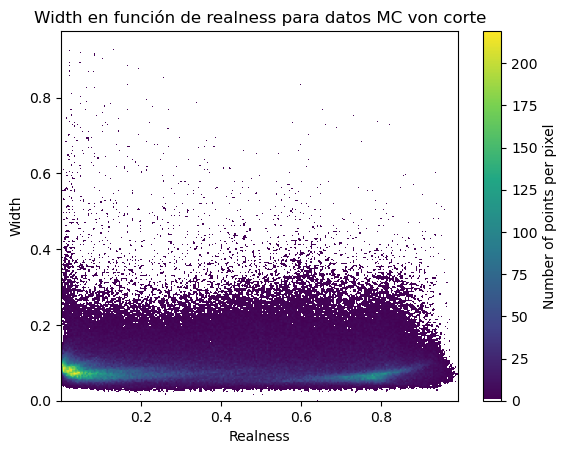

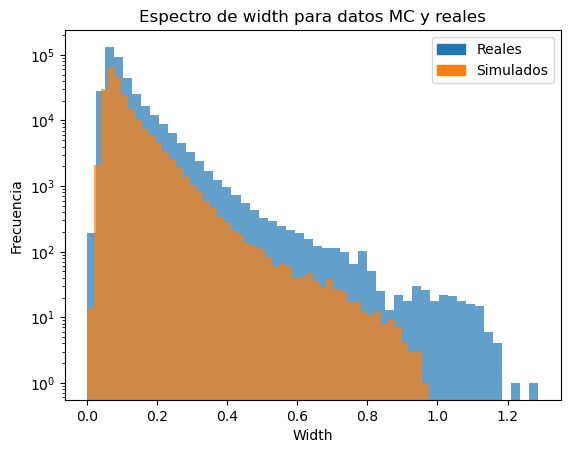

In [15]:
x_int = y_pred_intcut[:,0]
y_int = X_test_intcut[:,4]
label = y_test_intcut

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Width')
plt.title('Width en función de realness para datos reales con corte')
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Width')
plt.title('Width en función de realness para datos MC von corte')
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plt.hist(y_label_0, 50, alpha = 0.7)
plt.hist(y_label_1, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Width')
plt.title('Espectro de width para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

#### Time gradient

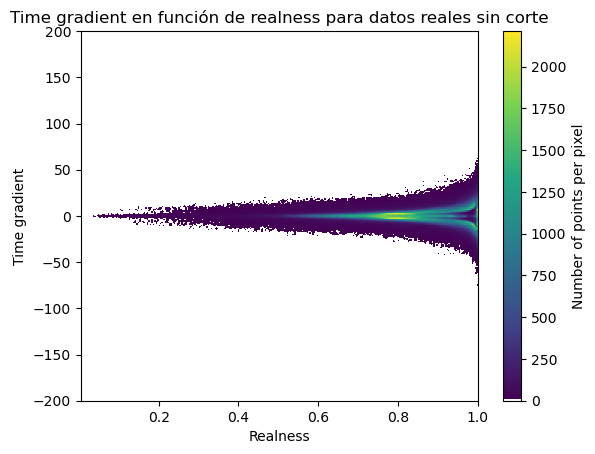

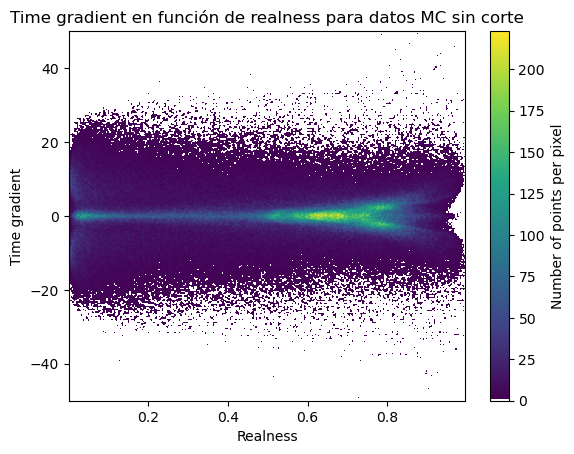

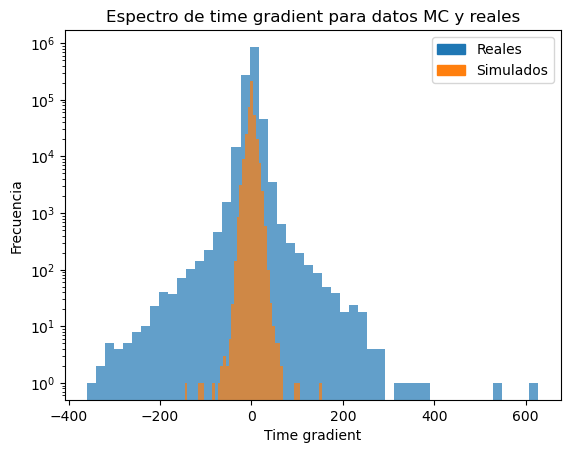

In [16]:
x_int = y_pred_total[:,0]
y_int = X_test_total[:,5]
label = y_test_total

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Time gradient')
plt.title('Time gradient en función de realness para datos reales sin corte')
plt.ylim(-200, 200)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Time gradient')
plt.title('Time gradient en función de realness para datos MC sin corte')
plt.ylim(-50, 50)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plt.hist(y_label_0, 50, alpha = 0.7)
plt.hist(y_label_1, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Time gradient')
plt.title('Espectro de time gradient para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

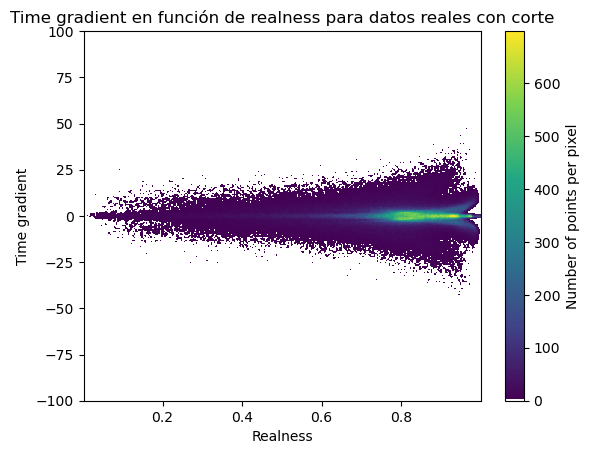

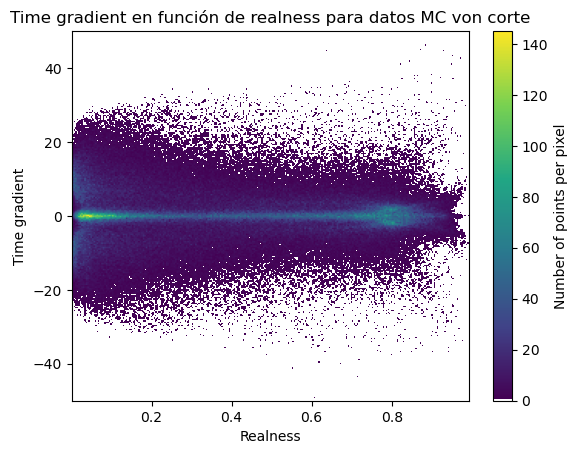

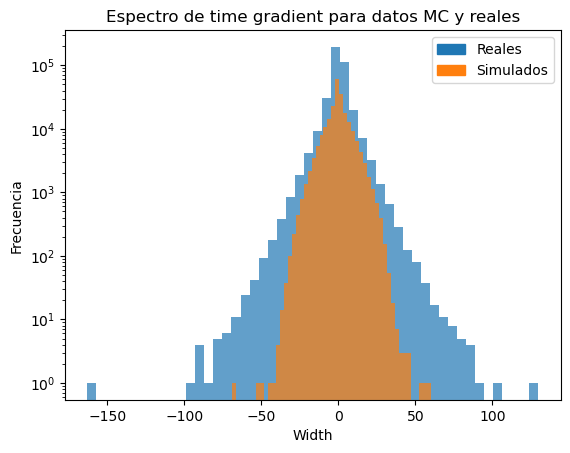

In [17]:
x_int = y_pred_intcut[:,0]
y_int = X_test_intcut[:,5]
label = y_test_intcut

# Dividir los puntos según la etiqueta
x_label_0 = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
y_label_0 = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
x_label_1 = [x_int[i] for i in range(len(x_int)) if label[i] == 1]
y_label_1 = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_0, y_label_0)
plt.xlabel('Realness')
plt.ylabel('Time gradient')
plt.title('Time gradient en función de realness para datos reales con corte')
plt.ylim(-100, 100)
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, x_label_1, y_label_1)
plt.xlabel('Realness')
plt.ylabel('Time gradient')
plt.title('Time gradient en función de realness para datos MC von corte')
plt.ylim(-50, 50)
plt.show()

# Representamos como es el espectro de los dos en escala log-log
plt.hist(y_label_0, 50, alpha = 0.7)
plt.hist(y_label_1, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Width')
plt.title('Espectro de time gradient para datos MC y reales')
reales = mpatches.Patch(color='#1f77b4', label='Reales')
simulados = mpatches.Patch(color='#ff7f0e', label='Simulados')
plt.legend(handles=[reales, simulados])
plt.show()

En general, los espectros simulados y los reales difieren un poco para todos los parámetros de la simulación. Lo más relevante son las diferentes pendientes de la intensidad, pero esto es debido a que se simulan con una energía de E^(-2.0) en vez de E^(-2.7) y probablemente el resto de parámetros difieran en el espectro por el mismo motivo.

### 2.2 Parámetros en función de otros parámetros

Ahora vamos a representar cada parámetro frente al otro para ver si encontramos algún patrón diferenciable entre MC y reales:

In [18]:
# Todos los datos
realness = y_pred_total[:,0]
label = y_test_total

real = [x_int[i] for i in range(len(x_int)) if label[i] == 0]
simu = [x_int[i] for i in range(len(x_int)) if label[i] == 1]

# Parámetros de Hillas
y_int = X_test_total[:,0]
y_skw = X_test_total[:,1]
y_kur = X_test_total[:,2]
y_len = X_test_total[:,3]
y_wid = X_test_total[:,4]
y_tim = X_test_total[:,5]

y_int_real = [y_int[i] for i in range(len(y_int)) if label[i] == 0]
y_int_simu = [y_int[i] for i in range(len(y_int)) if label[i] == 1]

y_skw_real = [y_skw[i] for i in range(len(y_skw)) if label[i] == 0]
y_skw_simu = [y_skw[i] for i in range(len(y_skw)) if label[i] == 1]

y_kur_real = [y_kur[i] for i in range(len(y_kur)) if label[i] == 0]
y_kur_simu = [y_kur[i] for i in range(len(y_kur)) if label[i] == 1]

y_len_real = [y_len[i] for i in range(len(y_len)) if label[i] == 0]
y_len_simu = [y_len[i] for i in range(len(y_len)) if label[i] == 1]

y_wid_real = [y_wid[i] for i in range(len(y_wid)) if label[i] == 0]
y_wid_simu = [y_wid[i] for i in range(len(y_wid)) if label[i] == 1]

y_tim_real = [y_tim[i] for i in range(len(y_tim)) if label[i] == 0]
y_tim_simu = [y_tim[i] for i in range(len(y_tim)) if label[i] == 1]

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import mpl_scatter_density

def using_mpl_scatter_density(ax, x, y):
    if np.all(x > 0):
        ax.set_xscale('log')
    if np.all(y > 0):
        ax.set_yscale('log')
    density = ax.scatter_density(x, y, cmap=white_viridis)

titles = ['Intensity', 'Skweness', 'Kurtosis', 'Length', 'Width', 'Time slope']

matriz_real = np.vstack((y_int_real, y_skw_real, y_kur_real, y_len_real, y_wid_real, y_tim_real))
matriz_simu = np.vstack((y_int_simu, y_skw_simu, y_kur_simu, y_len_simu, y_wid_simu, y_tim_simu))

#### Datos reales

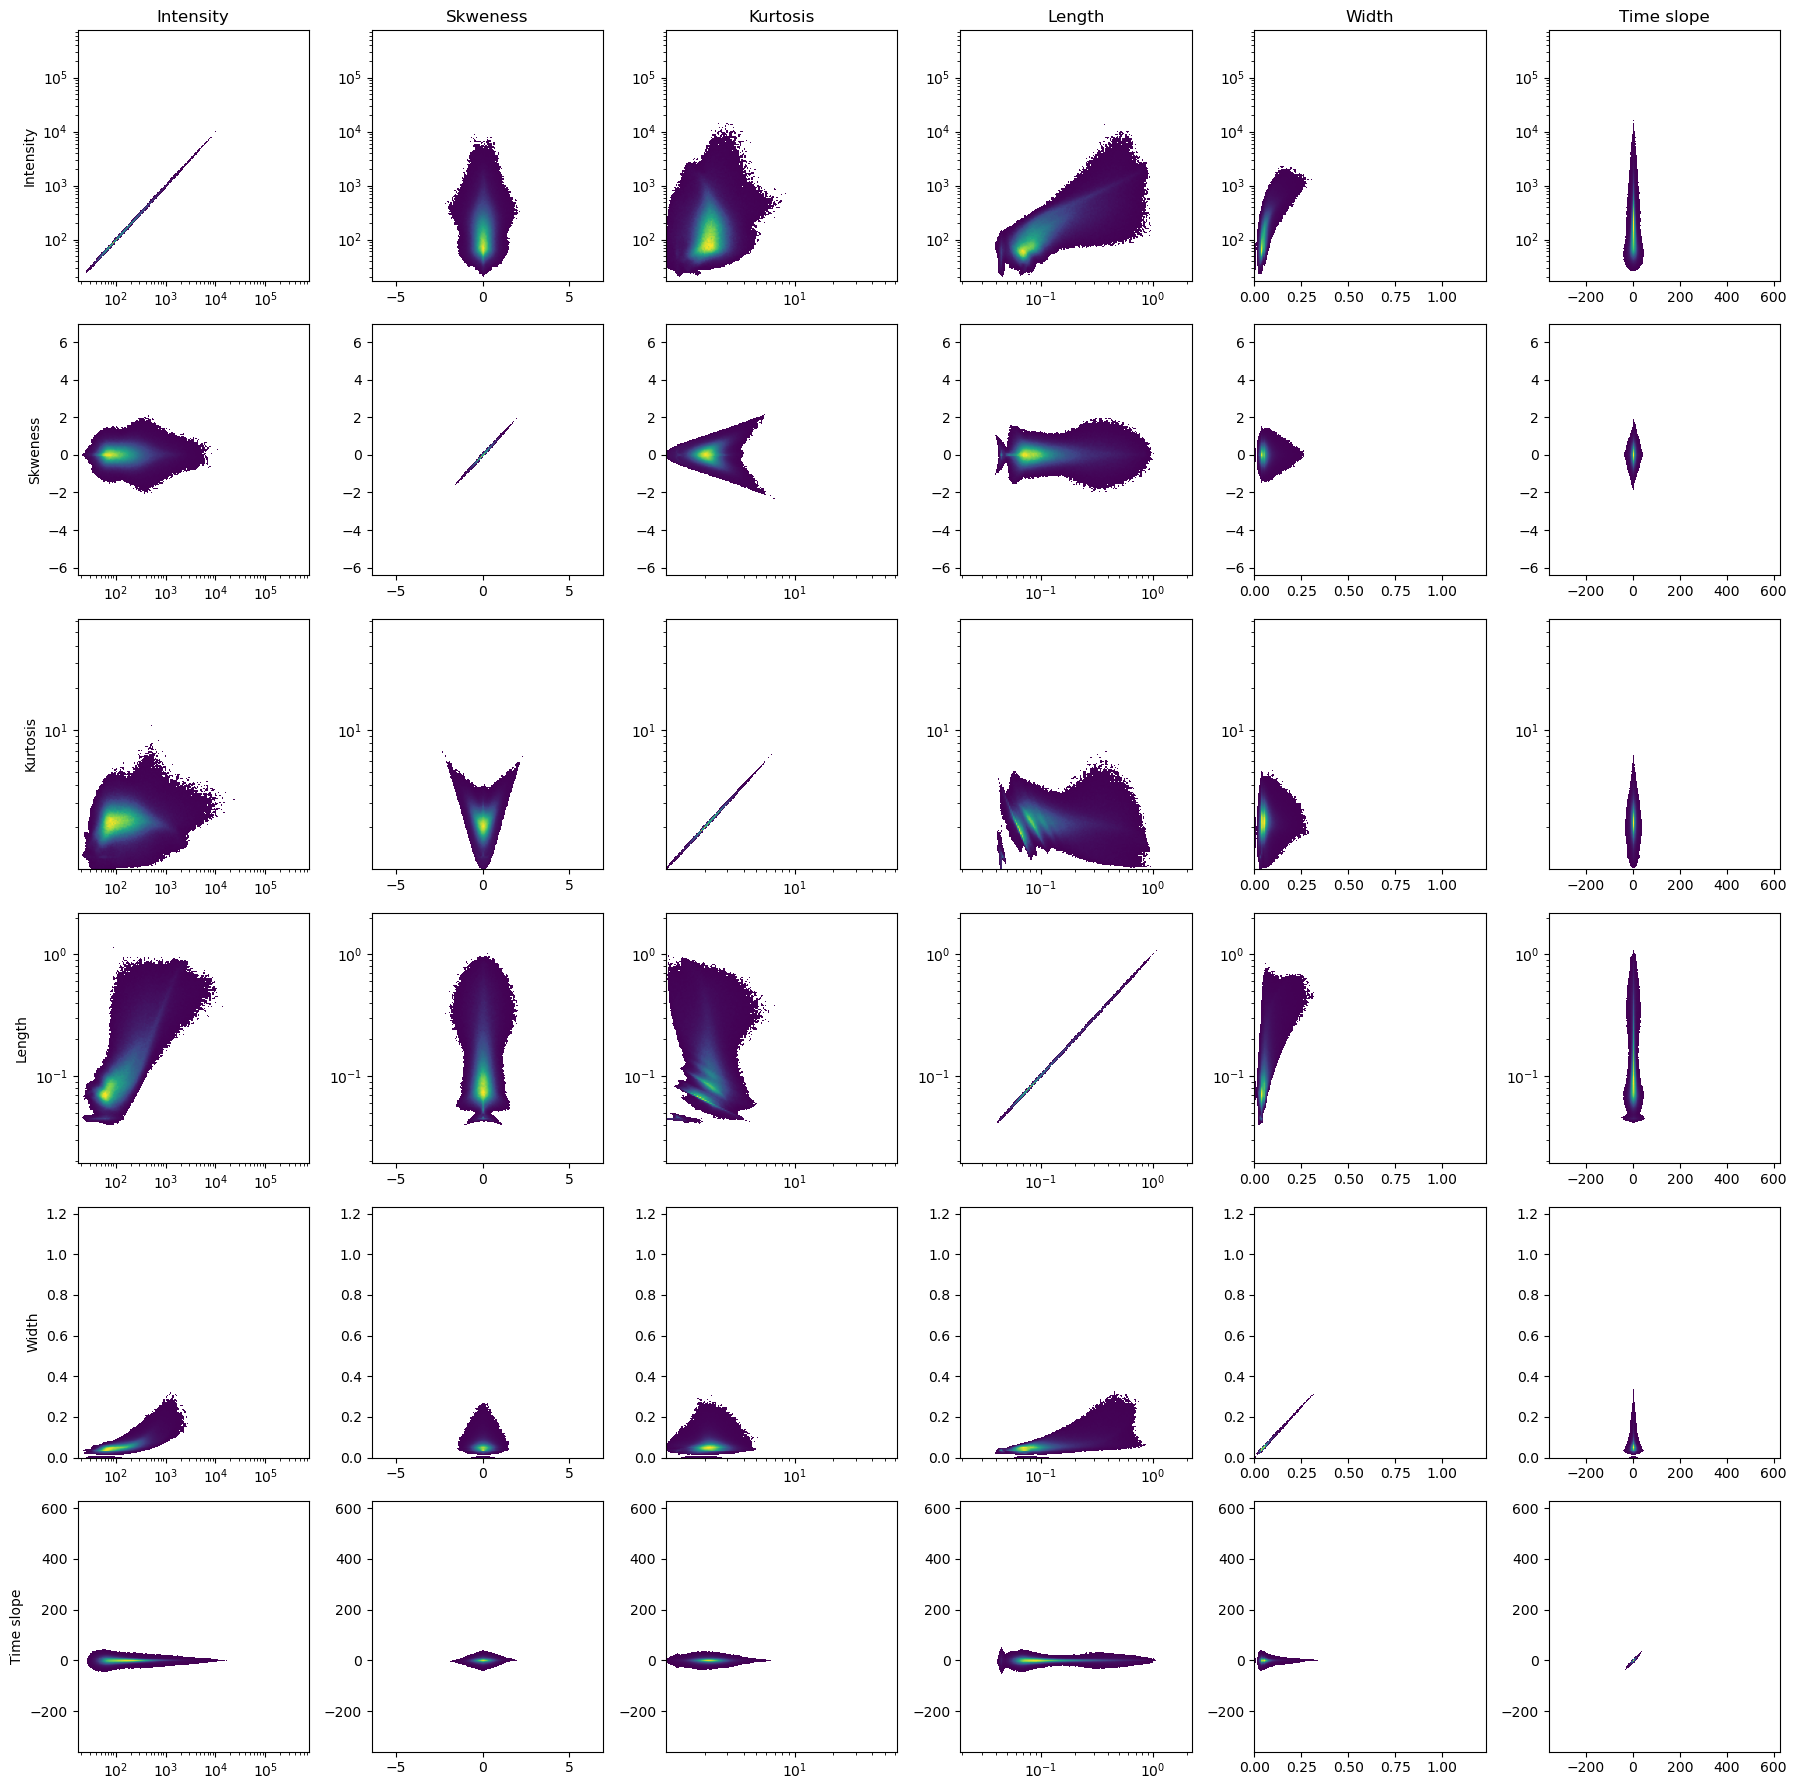

In [20]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, matriz_real[j, :], matriz_real[i, :])
        
plt.tight_layout()
plt.show()

#### Simulados

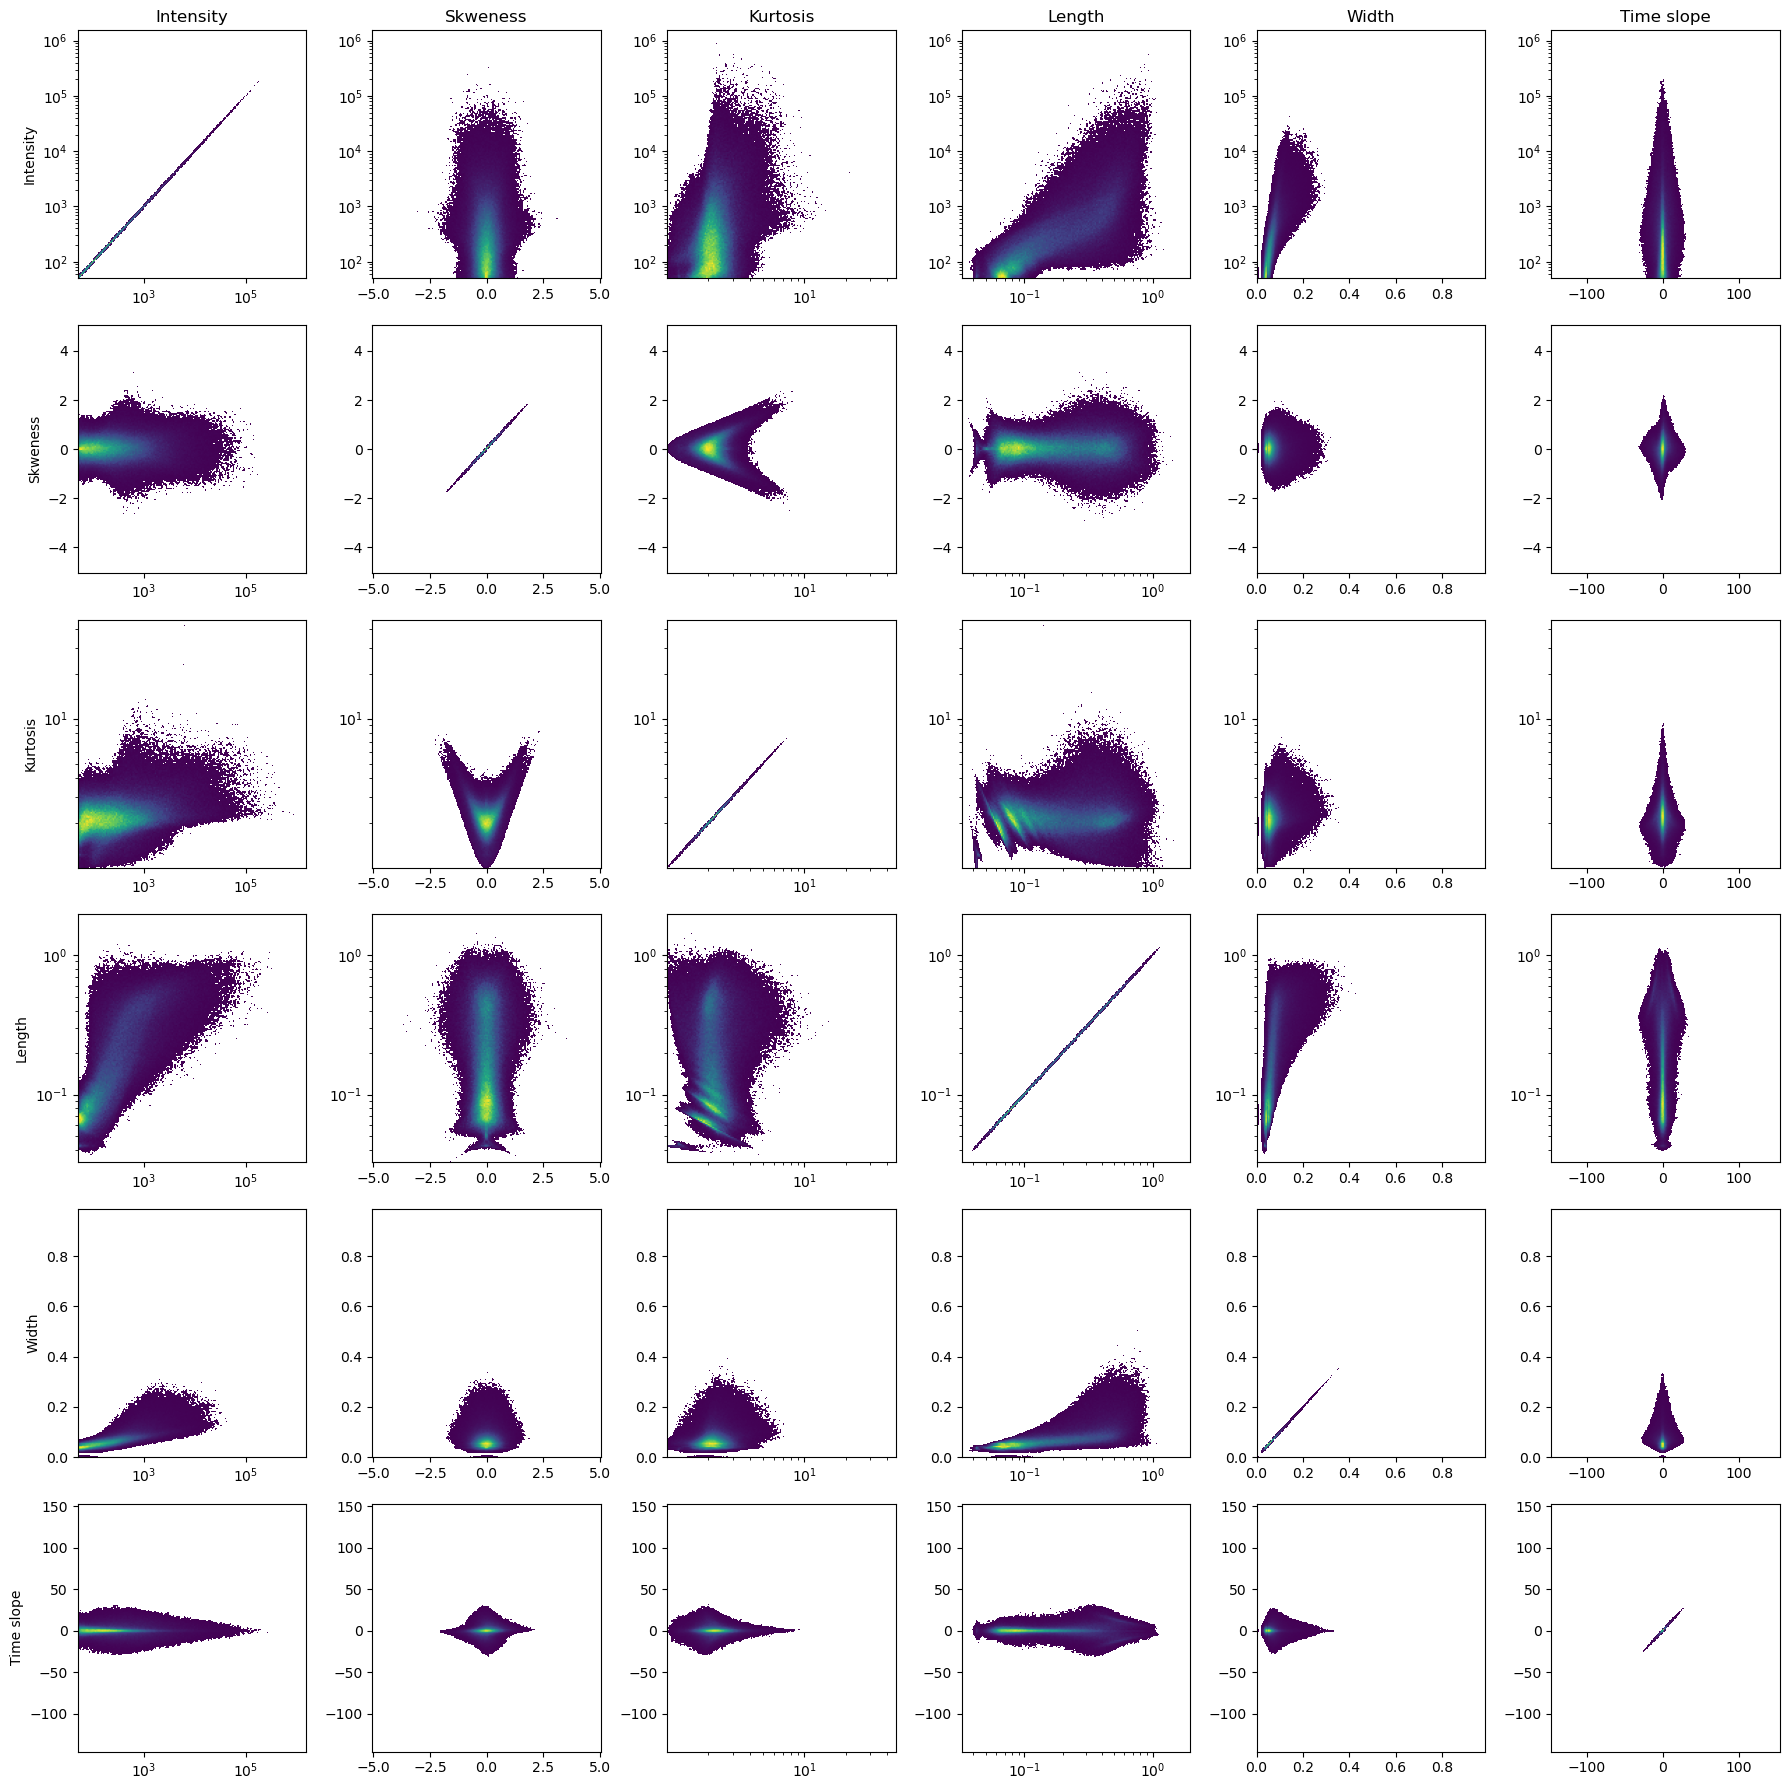

In [21]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")
        
        using_mpl_scatter_density(ax, matriz_simu[j, :], matriz_simu[i, :])

plt.tight_layout()
plt.show()

Realmente los resultados de los datos simulados contra los reales son bastante similares, encontrando la mayor diferencia simplemente en que los simulados tienen una mayor dispersión por venir supongo de simulaciones de MonteCarlo... así que por las relaciones entre variables no podemos tirar.

Lo más prometedor son los espectros y la pendiente de la energía de los datos reales y simulados.

## 3. Pendiente de reales y simulados

Ahora vamos a estudiar el espectro de la energía de las simulaciones y los reales para ver si coinciden con E^(-2.0) y E^(-2.7) respectivamente y ver así si esta diferencia es la culpable de que el RF sepa distinguir tan bien sucesos reales de sucesos simulados.

In [31]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 0)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos simulados
X_df_simu = df_protongamma.drop("true_energy", axis=1)
y_df_simu = df_protongamma["true_energy"]

# Dataframe de datos reales
X_df_real = df_realC 

In [32]:
# Entrenamos un Regressor con datos simulados
X_train, X_test, y_train, y_test = train_test_split(X_df_simu, y_df_simu, test_size=0.25)
rf_simu = RandomForestRegressor(n_estimators=125)
rf_simu.fit(X_train, y_train)

RandomForestRegressor(n_estimators=125)

In [33]:
# Testeamos el Regressor con datos simulados
y_pred_simu = rf_simu.predict(X_test)

In [ ]:
np.savetxt("X_test_simu", X_test)
np.savetxt("X_train_simu", X_train)
np.savetxt("y_test_simu", y_test)
np.savetxt("y_train_simu", y_train)
np.savetxt("X_test_real", X_df_real)

np.savetxt("y_pred_simu", y_pred_simu)
np.savetxt("y_pred_real", y_pred_real)
np.savetxt("y_simu_espectro", y_df_simu)

In [22]:
# Cargamos los datos generados anteriormente para no tener que volver a entrenar el RandomForest:
X_test_simu = np.loadtxt("X_test_simu")
X_train_simu = np.loadtxt("X_train_simu")
y_test_simu = np.loadtxt("y_test_simu")
y_train_simu = np.loadtxt("y_train_simu")
X_test_real = np.loadtxt("X_test_real")

y_pred_simu = np.loadtxt("y_pred_simu")
y_pred_real = np.loadtxt("y_pred_real")
y_simu_espectro = np.loadtxt("y_simu_espectro")

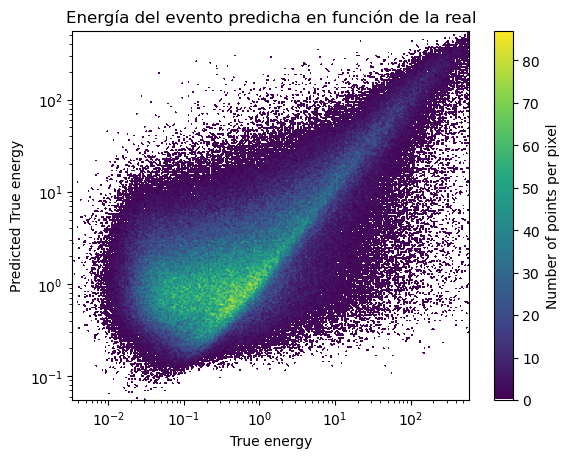

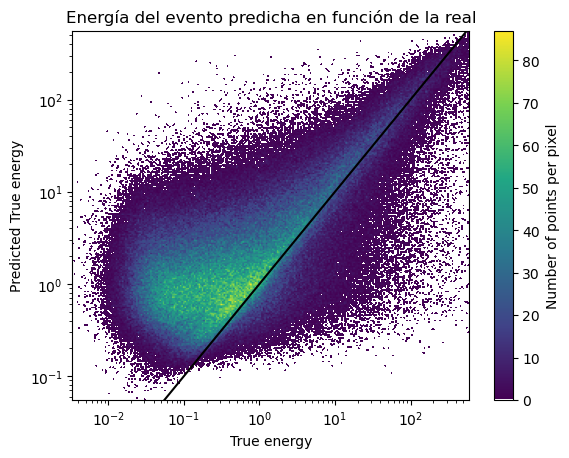

In [23]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

# Como de los datos simulados sí sabemos la true_energy podemos comparar los resultados
fig = plt.figure()
using_mpl_scatter_density(fig, y_test_simu, y_pred_simu)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.yscale('log')
plt.xscale('log')
plt.title('Energía del evento predicha en función de la real')
plt.show()

# Como de los datos simulados sí sabemos la true_energy podemos comparar los resultados. Añadimos la línea recta de aciertos
fig = plt.figure()
using_mpl_scatter_density(fig, y_test_simu, y_pred_simu)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.axline((1, 1), slope=1, c="k")
plt.yscale('log')
plt.xscale('log')
plt.title('Energía del evento predicha en función de la real')
plt.show()

In [ ]:
# Testeamos el Regressor con datos reales
y_pred_real = rf_simu.predict(X_df_real)

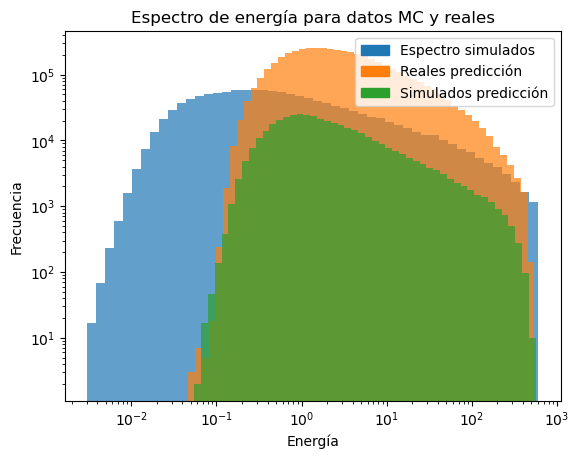

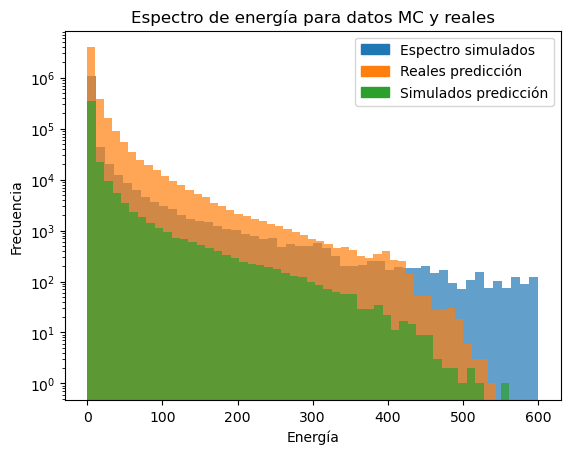

In [24]:
# Como de los datos reales no sabemos la true_energy podemos representar el espectro
plot_loghist(y_train_simu, 50)
plot_loghist(y_pred_real, 50)
plot_loghist(y_pred_simu, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energía para datos MC y reales')
simulados = mpatches.Patch(color='#2ca02c', label='Simulados predicción')
reales = mpatches.Patch(color='#ff7f0e', label='Reales predicción')
simulados2 = mpatches.Patch(color='#1f77b4', label='Espectro simulados')
plt.legend(handles=[simulados2, reales, simulados])
plt.show()

# Como de los datos reales no sabemos la true_energy podemos representar el espectro
plt.hist(y_train_simu, 50, alpha = 0.7)
plt.hist(y_pred_real, 50, alpha = 0.7)
plt.hist(y_pred_simu, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energía para datos MC y reales')
simulados = mpatches.Patch(color='#2ca02c', label='Simulados predicción')
reales = mpatches.Patch(color='#ff7f0e', label='Reales predicción')
simulados2 = mpatches.Patch(color='#1f77b4', label='Espectro simulados')
plt.legend(handles=[simulados2, reales, simulados])
plt.show()

Vemos que los espectros no llegan a energías tan bajas ya que el RF no ha tomado las suficientes decisiones y eso que no hemos puesto max_depth... Así que debemos calcular las pendientes con estos resultados aunque no sean las exactas.

### 3.1 Cálculo de la pendiente

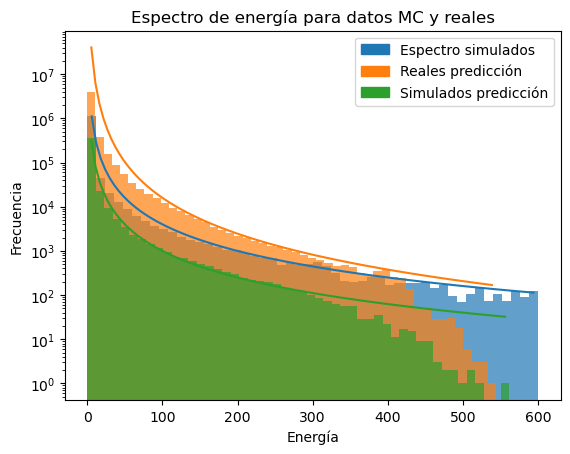

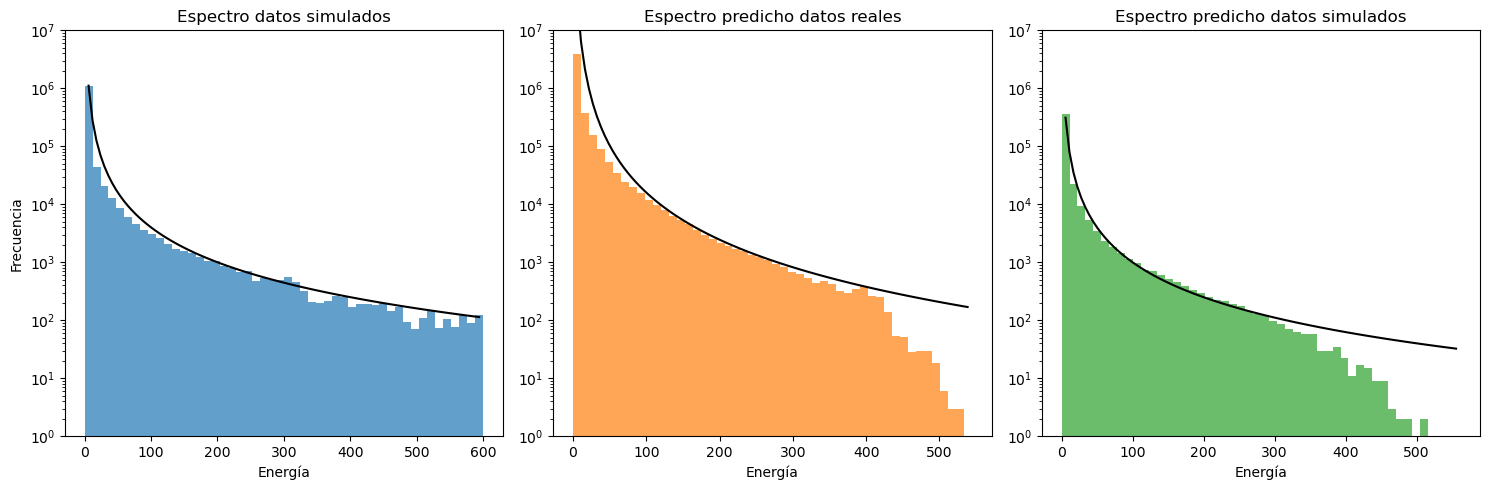

In [25]:
# Calcular el histograma
hist, bin_edges = np.histogram(y_train_simu, bins=50, density=True)
hist2, bin_edges2 = np.histogram(y_pred_real, bins=50, density=True)
hist3, bin_edges3 = np.histogram(y_pred_simu, bins=50, density=True)

# Calcular los centros de los bins
x_data = (bin_edges[1:] + bin_edges[:-1]) / 2
x_data2 = (bin_edges2[1:] + bin_edges2[:-1]) / 2
x_data3 = (bin_edges3[1:] + bin_edges3[:-1]) / 2

# Generar datos para la curva ajustada
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = 40000000*x_fit**(-2.0)
x_fit2 = np.linspace(min(x_data2), max(x_data2), 100)
y_fit2 = 4000000000*x_fit2**(-2.7)
x_fit3 = np.linspace(min(x_data3), max(x_data3), 100)
y_fit3 = 10000000*x_fit3**(-2.0)

# Graficar histograma y curva ajustada
plt.hist(y_train_simu, 50, alpha = 0.7)
plt.hist(y_pred_real, 50, alpha = 0.7)
plt.hist(y_pred_simu, 50, alpha = 0.7)

plt.plot(x_fit, y_fit, '#1f77b4')
plt.plot(x_fit2, y_fit2, '#ff7f0e')
plt.plot(x_fit3, y_fit3, '#2ca02c')

plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energía para datos MC y reales')
simulados = mpatches.Patch(color='#2ca02c', label='Simulados predicción')
reales = mpatches.Patch(color='#ff7f0e', label='Reales predicción')
simulados2 = mpatches.Patch(color='#1f77b4', label='Espectro simulados')
plt.legend(handles=[simulados2, reales, simulados])
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(y_train_simu, 50, alpha = 0.7, color='#1f77b4')
axs[0].plot(x_fit, y_fit, 'k')
axs[0].set_yscale('log')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xlabel('Energía')
axs[0].set_title('Espectro datos simulados')
axs[0].set_ylim(1, 10000000)

axs[1].hist(y_pred_real, 50, alpha = 0.7, color='#ff7f0e')
axs[1].plot(x_fit2, y_fit2, 'k')
axs[1].set_yscale('log')
axs[1].set_xlabel('Energía')
axs[1].set_title('Espectro predicho datos reales')
axs[1].set_ylim(1, 10000000)

axs[2].hist(y_pred_simu, 50, alpha = 0.7, color='#2ca02c')
axs[2].plot(x_fit3, y_fit3, 'k')
axs[2].set_yscale('log')
axs[2].set_xlabel('Energía')
axs[2].set_title('Espectro predicho datos simulados')
axs[2].set_ylim(1, 10000000)

plt.tight_layout()
plt.show()

Como puede apreciarse, los ajustes a curvas E^(-2.0) para los espectros simulados y E^(-2.7) para el espectro real se ajustan muy bien. Es por esto que vamos a hacer lo comentado previamente, es decir:

1. Extremos los valores de true_energy del dataframe de parámetros simulados.
2. A cada valor de este array lo vamos a multiplicar por un valor P calculado tal que $P = \frac{E^{-2.7}}{E^{-2.0}}$ ya que así es cómo se obtiene el espectro real a partir del simulado (siempre y cuando sea E > 1).
3. Usando el nuevo parámetro P, creamos una función que, para cada valor de true_energy, nos lo devolverá con cierta probabilidad de devolverlo, sino la true_energy_corregida será 0 y sino se mantendrá el valor de true_energy.
4. Filtramos de nuesto datframe los valores con true_energy == 0 y ya tenemos nuestro espectro simulado corregido.
5. Ahora solo queda entrenar un RF y rezar para que los nuevos datos simulados sean los que lo confundan y no sepa cuándo son simulados y cuándo son reales.

#### Paso 1

In [67]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_proton = df_protons.dropna()
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Filtramos el dataframe para que tome valores de true energy > 1 ya que son los únicos que podemos usar
df_protongamma_filtrado = df_protongamma[df_protongamma['true_energy'] > 1]

true_energy_20 = df_protongamma_filtrado["true_energy"]

#### Paso 2

In [68]:
P = []
true_energy_20 = true_energy_20.values
for i in range(len(true_energy_20)):
    P.append(true_energy_20[i]**(-2.7) / true_energy_20[i]**(-2.0))

#### Paso 3

In [69]:
def sobrevive(proba, energy):
    # Crear un nuevo array para almacenar los números sobrevivientes
    sobrevivientes = []
    # Iterar sobre los números y las probabilidades
    for i, probabilidad in enumerate(proba):
        # Generar un número aleatorio entre 0 y 1
        aleatorio = np.random.rand()
        # Si el número aleatorio es menor o igual a la probabilidad, el número sobrevive
        if aleatorio <= proba[i]:
            sobrevivientes.append(energy[i])
        else:
            sobrevivientes.append(0)
    return sobrevivientes

true_energy_27 = sobrevive(P, true_energy_20)

#### Paso 4

In [70]:
# Eliminamos los que son 0 de true_energy_2.7
true_energy_27_filtrado = []
for i in range(len(true_energy_27)):
    if true_energy_27[i] > 0:
        true_energy_27_filtrado.append(true_energy_27[i])

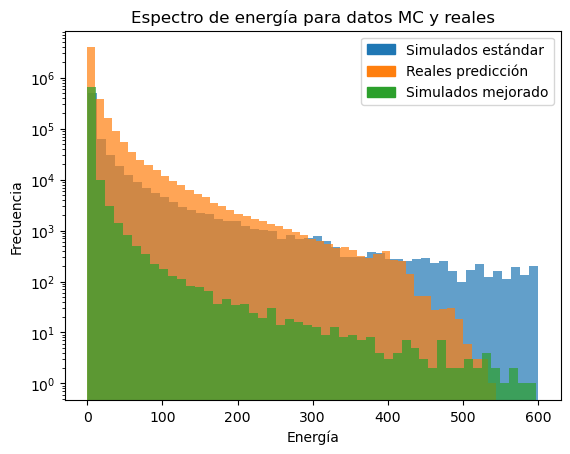

In [72]:
# Como de los datos reales no sabemos la true_energy podemos representar el espectro
plt.hist(true_energy_20, 50, alpha = 0.7)
plt.hist(y_pred_real, 50, alpha = 0.7)
plt.hist(true_energy_27, 50, alpha = 0.7)
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energía para datos MC y reales')
simulados = mpatches.Patch(color='#2ca02c', label='Simulados mejorado')
reales = mpatches.Patch(color='#ff7f0e', label='Reales predicción')
simulados2 = mpatches.Patch(color='#1f77b4', label='Simulados estándar')
plt.legend(handles=[simulados2, reales, simulados])
plt.show()

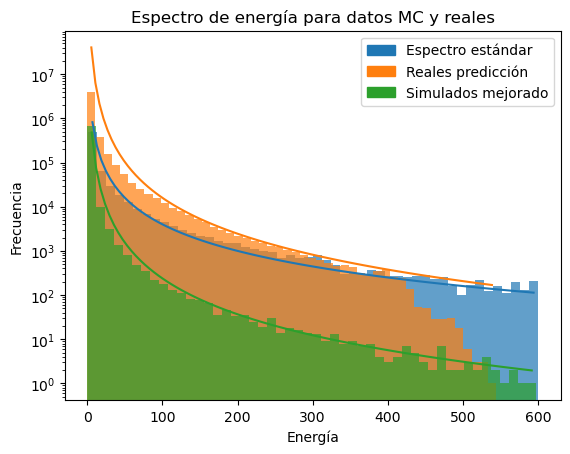

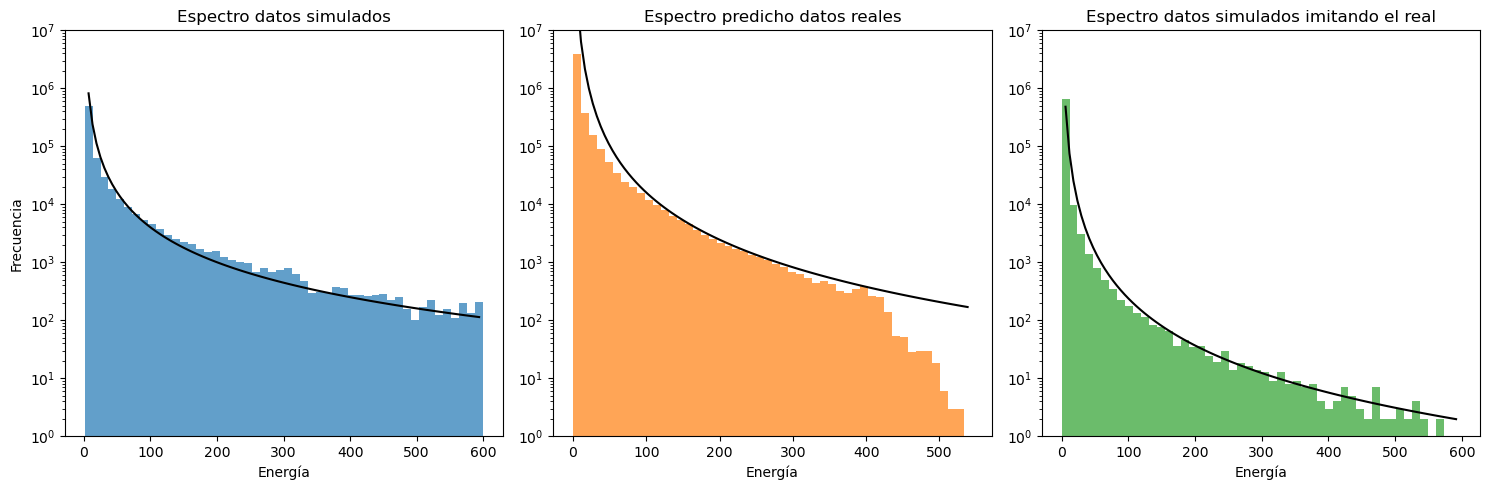

In [88]:
# Calcular el histograma
hist, bin_edges = np.histogram(true_energy_20, bins=50, density=True)
hist2, bin_edges2 = np.histogram(y_pred_real, bins=50, density=True)
hist3, bin_edges3 = np.histogram(true_energy_27, bins=50, density=True)

# Calcular los centros de los bins
x_data = (bin_edges[1:] + bin_edges[:-1]) / 2
x_data2 = (bin_edges2[1:] + bin_edges2[:-1]) / 2
x_data3 = (bin_edges3[1:] + bin_edges3[:-1]) / 2

# Generar datos para la curva ajustada
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = 40000000*x_fit**(-2.0)
x_fit2 = np.linspace(min(x_data2), max(x_data2), 100)
y_fit2 = 4000000000*x_fit2**(-2.7)
x_fit3 = np.linspace(min(x_data3), max(x_data3), 100)
y_fit3 = 60000000*x_fit3**(-2.7)

# Graficar histograma y curva ajustada
plt.hist(true_energy_20, 50, alpha = 0.7)
plt.hist(y_pred_real, 50, alpha = 0.7)
plt.hist(true_energy_27, 50, alpha = 0.7)

plt.plot(x_fit, y_fit, '#1f77b4')
plt.plot(x_fit2, y_fit2, '#ff7f0e')
plt.plot(x_fit3, y_fit3, '#2ca02c')

plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energía para datos MC y reales')
simulados = mpatches.Patch(color='#2ca02c', label='Simulados mejorado')
reales = mpatches.Patch(color='#ff7f0e', label='Reales predicción')
simulados2 = mpatches.Patch(color='#1f77b4', label='Espectro estándar')
plt.legend(handles=[simulados2, reales, simulados])
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(true_energy_20, 50, alpha = 0.7, color='#1f77b4')
axs[0].plot(x_fit, y_fit, 'k')
axs[0].set_yscale('log')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xlabel('Energía')
axs[0].set_title('Espectro datos simulados')
axs[0].set_ylim(1, 10000000)

axs[1].hist(y_pred_real, 50, alpha = 0.7, color='#ff7f0e')
axs[1].plot(x_fit2, y_fit2, 'k')
axs[1].set_yscale('log')
axs[1].set_xlabel('Energía')
axs[1].set_title('Espectro predicho datos reales')
axs[1].set_ylim(1, 10000000)

axs[2].hist(true_energy_27, 50, alpha = 0.7, color='#2ca02c')
axs[2].plot(x_fit3, y_fit3, 'k')
axs[2].set_yscale('log')
axs[2].set_xlabel('Energía')
axs[2].set_title('Espectro datos simulados imitando el real')
axs[2].set_ylim(1, 10000000)

plt.tight_layout()
plt.show()

Se puede ver que ahora el espectro de datos simulados sigue la misma tendencia que el espectro de datos reales... esperemos que ahora, usando el dataframe de datos simulados corregidos se confundan más los datos simulados de los que no.

### 3.2 Dataframe de datos simulados corregido

Ahora cada paso de modificación de true_energy hay que copiarlo en el dataframe entero:

In [2]:
# PASO 1
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_proton = df_protons.dropna()
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Filtramos el dataframe para que tome valores de true energy > 1 ya que son los únicos que podemos usar
df_protongamma_filtrado = df_protongamma[df_protongamma['true_energy'] > 1]
true_energy_20 = df_protongamma_filtrado["true_energy"]
eventos = len(true_energy_20)

# PASO 2
P = []
true_energy_20 = true_energy_20.values
for i in range(len(true_energy_20)):
    P.append(true_energy_20[i]**(-2.7) / true_energy_20[i]**(-2.0))

# PASO 3
def sobrevive(proba, energy):
    # Crear un nuevo array para almacenar los números sobrevivientes
    sobrevivientes = []
    # Iterar sobre los números y las probabilidades
    for i, probabilidad in enumerate(proba):
        # Generar un número aleatorio entre 0 y 1
        aleatorio = np.random.rand()
        # Si el número aleatorio es menor o igual a la probabilidad, el número sobrevive
        if aleatorio <= proba[i]:
            sobrevivientes.append(energy[i])
        else:
            sobrevivientes.append(0)
    return sobrevivientes

true_energy_27 = sobrevive(P, true_energy_20)

In [3]:
# PASO 4
# Filtramos el dataframe de simulados para los valores de true_energy_2.7 distintos a 0
df_protongamma_filtrado.loc[:, "true_energy_filter"] = true_energy_27

df_protongamma_filtrado = df_protongamma_filtrado[df_protongamma_filtrado['true_energy_filter'] != 0]

/tmp/ipykernel_18871/72312950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protongamma_filtrado.loc[:, "true_energy_filter"] = true_energy_27


####  Paso 5

Ahora con el nuevo datafame de datos simulados, solo falta unirlo al dataframe de datos reales y entrenar un RF

In [127]:
# Sacamos el dataframe de datos simulados finales
df_protongamma_simu = df_protongamma_filtrado.drop("true_energy", axis=1)
df_protongamma_simu = df_protongamma_simu.drop("true_energy_filter", axis=1)
df_protongamma_simu = df_protongamma_simu.dropna()

# Sacamos el dataframe de datos reales finales

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos simulados
df_real = df_realC

# Mostramos el tamaño de cada dataframe para ver si los datos están muy descompensados
print(df_protongamma_simu.shape)
print(df_real.shape)

(237235, 6)
(4795246, 6)


Hay 20 veces más datos reales que simulados... vamos a disminuir dicha proproción porque sino vamos a obtener malos resultados (luego probaremos sin disminuir la proporción para ver si esto era cierto)

In [128]:
df_real_menor = df_real.head(237235)

In [129]:
# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protongamma_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real_menor)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_protongamma_simu, df_real_menor], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs_1 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

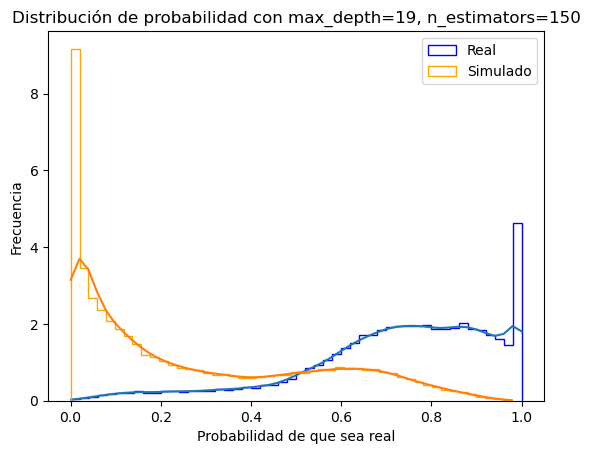

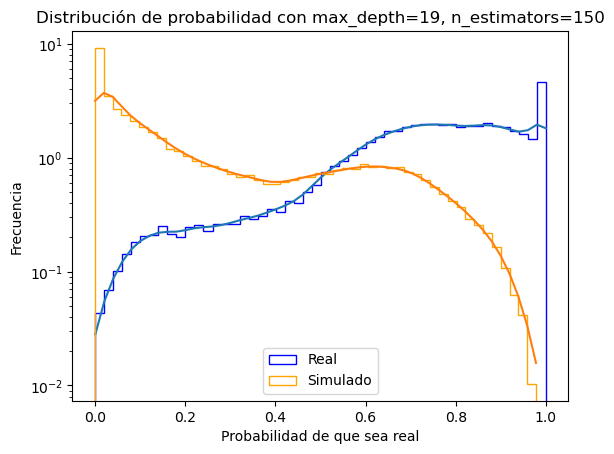

In [131]:
y_pred = (rfrs_1.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

Hay madre que resultados tan malos... vamos a probar ahora sin filtrar los datos reales...

In [132]:
# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protongamma_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_protongamma_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs_2 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

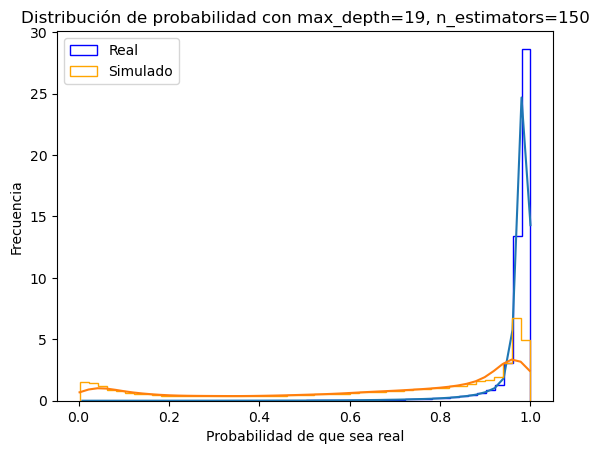

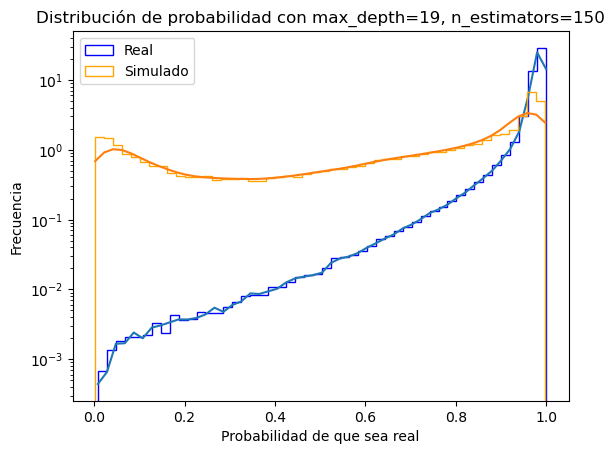

In [134]:
y_pred = (rfrs_2.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

Parece que van mejor los resultados... tampoco son ninguna locura pero bueno

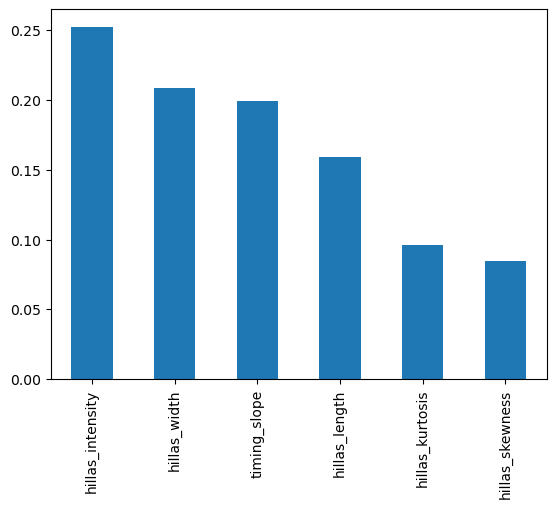

In [135]:
feature_importances = pd.Series(rfrs_2.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

Ahora primero voy a mirar si he hecho bien el filtro del dataframe representando el espectro de energías... que yo creo que sí porque he hecho lo mismo que usando el vector solo la verdad.

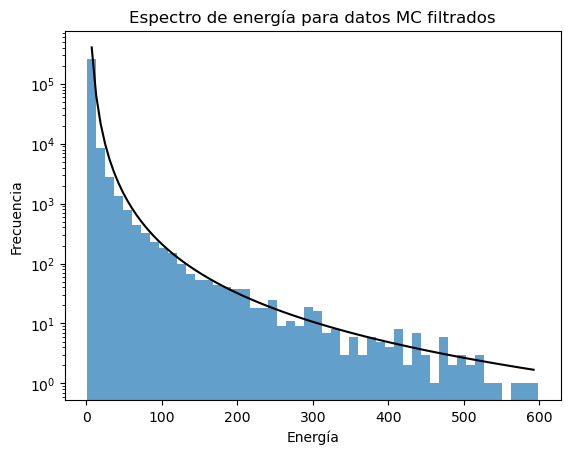

In [138]:
# Espectro de energía simulado filtrado para parecerse al espectro real
true_energy_27 = df_protongamma_filtrado['true_energy_filter']

# Ajuste exponencial
hist, bin_edges = np.histogram(true_energy_27, bins=50, density=True)
x_data = (bin_edges[1:] + bin_edges[:-1]) / 2
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = 40000000*x_fit2**(-2.7)

plt.hist(true_energy_27, 50, alpha = 0.7)

plt.plot(x_fit, y_fit, 'k')

plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energía para datos MC filtrados')
plt.show()

Está clavado para -2.7

La última idea es ver si con intensity > 200 mejoran...

In [4]:
# Sacamos el dataframe de datos simulados finales
df_protongamma_simu = df_protongamma_filtrado.drop("true_energy", axis=1)
df_protongamma_simu = df_protongamma_simu.drop("true_energy_filter", axis=1)
df_protongamma_simu = df_protongamma_simu.dropna()

# Sacamos el dataframe de datos reales finales
# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos
df_simu = df_protongamma_simu
df_real = df_realC

# Los filtramos para inte
df_simu = df_simu[df_simu['hillas_intensity']>200]
df_real = df_real[df_real['hillas_intensity']>200]

# Mostramos el tamaño de cada dataframe para ver si los datos están muy descompensados
print(df_simu.shape)
print(df_real.shape)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

(165992, 6)
(1545761, 6)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs_3 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs_3.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

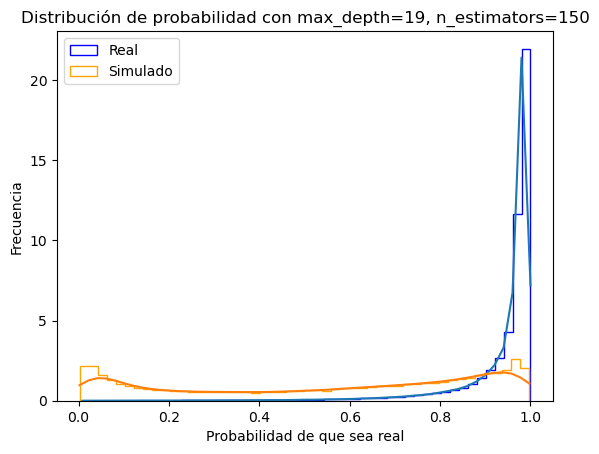

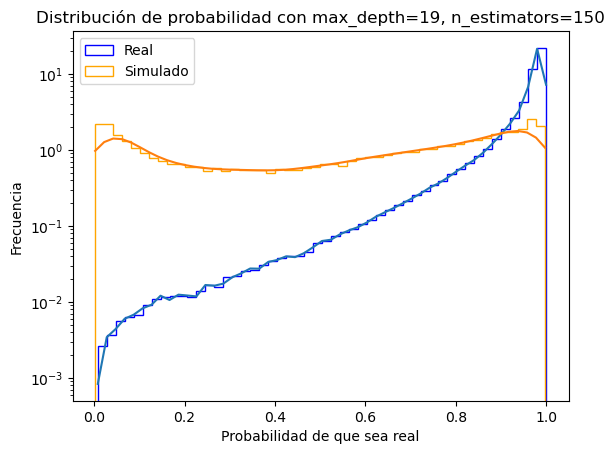

In [6]:
y_pred = (rfrs_3.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

... última oportunidad: filtrar menos datos reales a ver si cuela...

In [7]:
# Sacamos el dataframe de datos simulados finales
df_protongamma_simu = df_protongamma_filtrado.drop("true_energy", axis=1)
df_protongamma_simu = df_protongamma_simu.drop("true_energy_filter", axis=1)
df_protongamma_simu = df_protongamma_simu.dropna()

# Sacamos el dataframe de datos reales finales
# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos
df_simu = df_protongamma_simu
df_real = df_realC

# Los filtramos para inte
df_simu = df_simu[df_simu['hillas_intensity']>200]
df_real = df_real[df_real['hillas_intensity']>200]

# Mostramos el tamaño de cada dataframe para ver si los datos están muy descompensados
print(df_protongamma_simu.shape)
print(df_real.shape)

df_real_menor = df_real.head(500000)

(237702, 6)
(1545761, 6)


In [9]:
# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real_menor)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real_menor], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs_4 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs_4.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

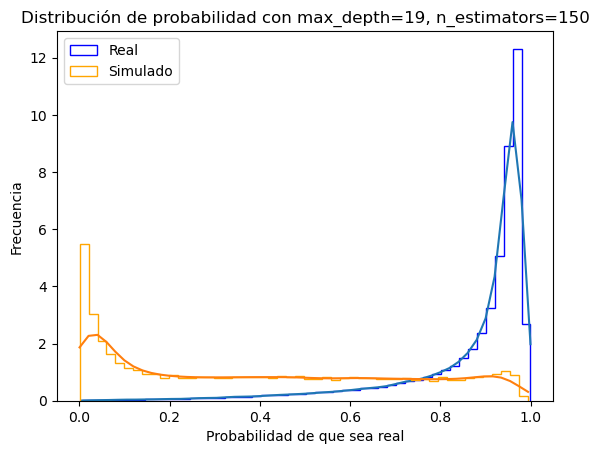

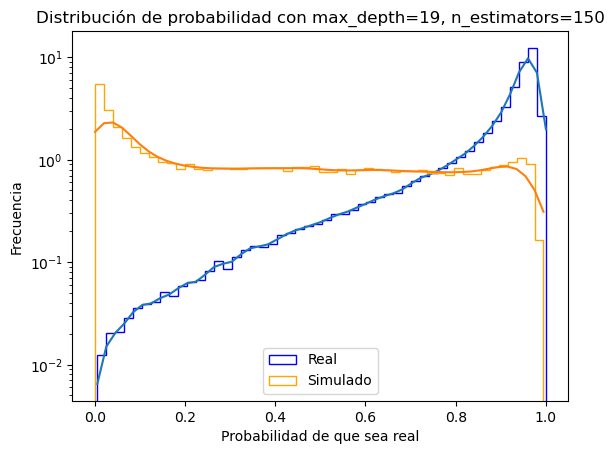

In [11]:
y_pred = (rfrs_4.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

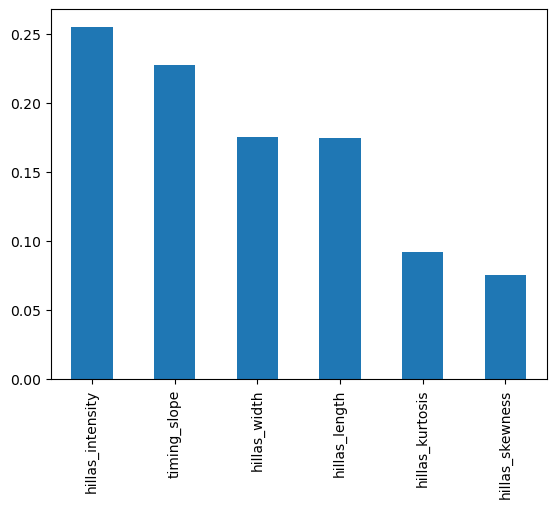

In [12]:
feature_importances = pd.Series(rfrs_4.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()